In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy.stats import logistic
from scipy.stats import chi2
from scipy.stats import kstest

In [2]:
def f(theta, X):
    n = len(X)
    q = np.exp(-(X-theta))/(1 + np.exp(-(X-theta)))
    return n - 2*np.sum(q)

def g(theta, X):
    n = len(X)
    q = np.exp(-(X-theta))/(1 + np.exp(-(X-theta)))**2
    return -2*np.sum(q)

In [3]:
def newtonRaphson(x0, X, e=1e-6, N=1000):
    step = 1
    flag = 1
    condition = True
    while condition:
        if g(x0, X) == 0.0:
            break
        
        x1 = x0 - f(x0, X)/g(x0, X)
        x0 = x1
        step = step + 1
        
        if step > N:
            flag = 0
            break
        
        condition = abs(f(x1, X)) > e
    
    if flag==1:
        return x1
    else:
        return None

In [4]:
def log_likelihood (theta, X): 
    C = X - theta
    return np.sum(-C - 2*np.log(1 + np.exp(-C)))

In [5]:
sizes = [10, 20, 50, 100, 200]

data = {}
emv = []

LR = []
W = []
S = []

for size in sizes:
    samples = []
    emv_vals = []
    LRs = []
    Ws = []
    Ss = []
    for m in range(1000):
        X = logistic.rvs(size=size)
        samples += [X]
        m = np.mean(X)
        mle = newtonRaphson(m, X)
        emv_vals += [mle]
        LRs += [2*(log_likelihood(mle, X) - log_likelihood(0, X))]
        Ws += [size*(1/3)*(mle**2)]
        Ss += [3*f(0, X)**2/size]
        
    data[size] = samples
    emv += [emv_vals]
    LR += [LRs]
    W += [Ws]
    S += [Ss]
    
LR = np.array(LR)
W = np.array(W)
S = np.array(S)

In [6]:
def K2 (data, bounds, probs):
    y = []
    n = len(data)
    for k, bound in enumerate(bounds):
        if k==0:
            ii = data <= bound
        else:
            ii = (data <= bound) & (data> bounds[k-1])
        if k==len(bounds)-1:
            jj = (data > bound)
            
        y += [len(data[ii])]
    
    y += [len(data[jj])]
    
    s = 0
    for j, p in enumerate(probs):
        s += (y[j] - n*p)**2/(n*p)
    
    return s

In [7]:
bounds = [chi2.ppf(k/7, 1) for k in range(1,7)]
bounds = np.array(bounds)

probs = [1/7]*7

K2_LR = []
K2_W = []
K2_S = []

for k in range(len(sizes)):
    K2_LR += [K2(LR[k], bounds, probs)]
    K2_W += [K2(W[k], bounds, probs)]
    K2_S += [K2(S[k], bounds, probs)]
    
K2_LR = np.array(K2_LR)
K2_W = np.array(K2_W)
K2_S = np.array(K2_S)

In [8]:
p_LR = 1 - chi2.cdf(K2_LR, 6)
p_W = 1 - chi2.cdf(K2_W, 6)
p_S = 1 - chi2.cdf(K2_S, 6)

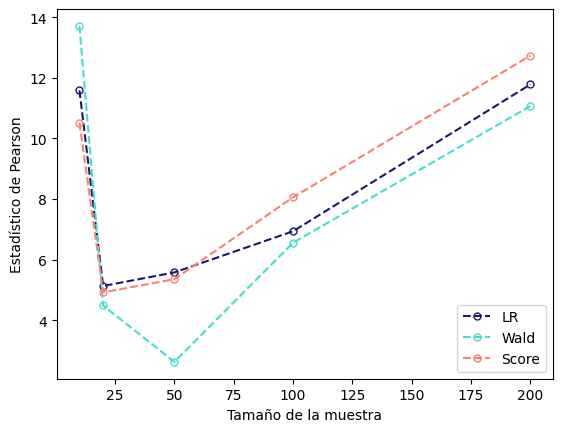

In [9]:
plt.plot(sizes, K2_LR, ls='--', color='midnightblue', marker='o', ms=5,
         fillstyle='none', label='LR')
plt.plot(sizes, K2_W, ls='--', color='turquoise', marker='o', ms=5,
         fillstyle='none', label='Wald')
plt.plot(sizes, K2_S, ls='--', color='salmon', marker='o', ms=5,
         fillstyle='none', label='Score')

plt.xlabel('Tamaño de la muestra')
plt.ylabel('Estadístico de Pearson')
plt.legend()
plt.savefig('Pearson')

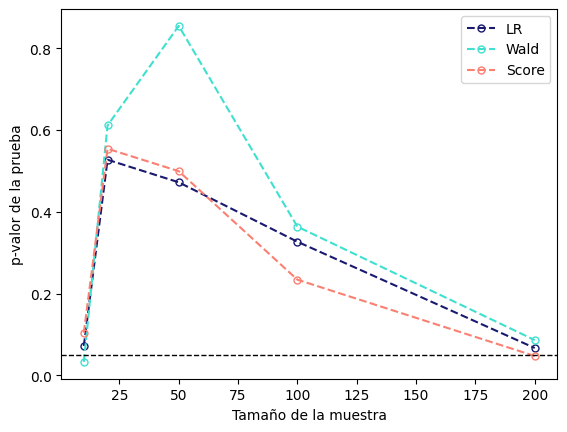

In [10]:
plt.plot(sizes, p_LR, ls='--', color='midnightblue', marker='o', ms=5,
         fillstyle='none', label='LR')
plt.plot(sizes, p_W, ls='--', color='turquoise', marker='o', ms=5,
         fillstyle='none', label='Wald')
plt.plot(sizes, p_S, ls='--', color='salmon', marker='o', ms=5,
         fillstyle='none', label='Score')

plt.xlabel('Tamaño de la muestra')
plt.ylabel('p-valor de la prueba')
plt.axhline(0.05, linewidth=1, color='k', ls='--')
plt.legend()
plt.savefig('p-val_Pearson')

In [11]:
KS_LR = []
KS_W = []
KS_S = []

p_LR = []
p_W = []
p_S = []

for k in range(len(sizes)):
    KS_LR += [kstest(LR[k], lambda x: chi2.cdf(x,1))[0]]
    KS_W += [kstest(W[k], lambda x: chi2.cdf(x,1))[0]]
    KS_S += [kstest(S[k], lambda x: chi2.cdf(x,1))[0]]
    
    p_LR += [kstest(LR[k], lambda x: chi2.cdf(x,1))[1]]
    p_W += [kstest(W[k], lambda x: chi2.cdf(x,1))[1]]
    p_S += [kstest(S[k], lambda x: chi2.cdf(x,1))[1]]
    
    
KS_LR = np.array(KS_LR)
KS_W = np.array(KS_W)
KS_S = np.array(KS_S)

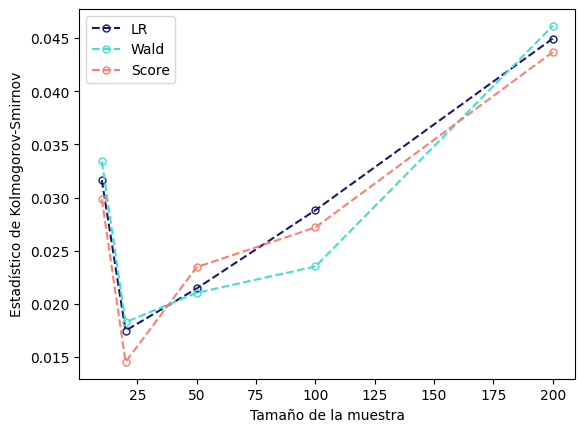

In [12]:
plt.plot(sizes, KS_LR, ls='--', color='midnightblue', marker='o', ms=5,
         fillstyle='none', label='LR')
plt.plot(sizes, KS_W, ls='--', color='turquoise', marker='o', ms=5,
         fillstyle='none', label='Wald')
plt.plot(sizes, KS_S, ls='--', color='salmon', marker='o', ms=5,
         fillstyle='none', label='Score')

plt.xlabel('Tamaño de la muestra')
plt.ylabel('Estadístico de Kolmogorov-Smirnov')
plt.legend()
plt.savefig('KS')

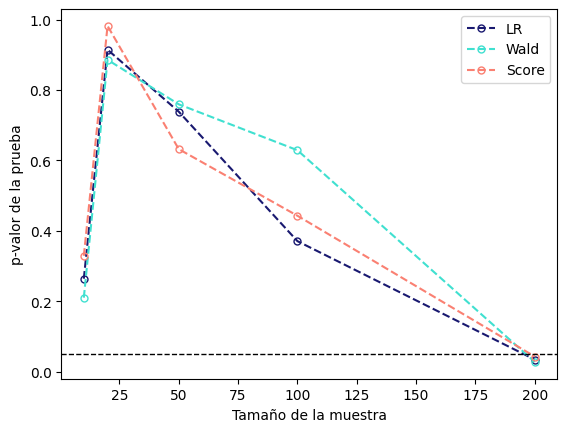

In [13]:
plt.plot(sizes, p_LR, ls='--', color='midnightblue', marker='o', ms=5,
         fillstyle='none', label='LR')
plt.plot(sizes, p_W, ls='--', color='turquoise', marker='o', ms=5,
         fillstyle='none', label='Wald')
plt.plot(sizes, p_S, ls='--', color='salmon', marker='o', ms=5,
         fillstyle='none', label='Score')

plt.xlabel('Tamaño de la muestra')
plt.ylabel('p-valor de la prueba')
plt.axhline(0.05, linewidth=1, color='k', ls='--')
plt.legend()
plt.savefig('p-val_KS')